/var/folders/gs/_8hlmzn17p763ggbbr6clf6m0000gn/T/ipykernel_85685/2212395550.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_temp.groupby('bin').agg(
/var/folders/gs/_8hlmzn17p763ggbbr6clf6m0000gn/T/ipykernel_85685/2212395550.py:157: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('../results/complete_inefficiency_analysis.png', dpi=300, bbox_inches='tight')
/Users/kiki/Desktop/odds_scanner/sports_analytics/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


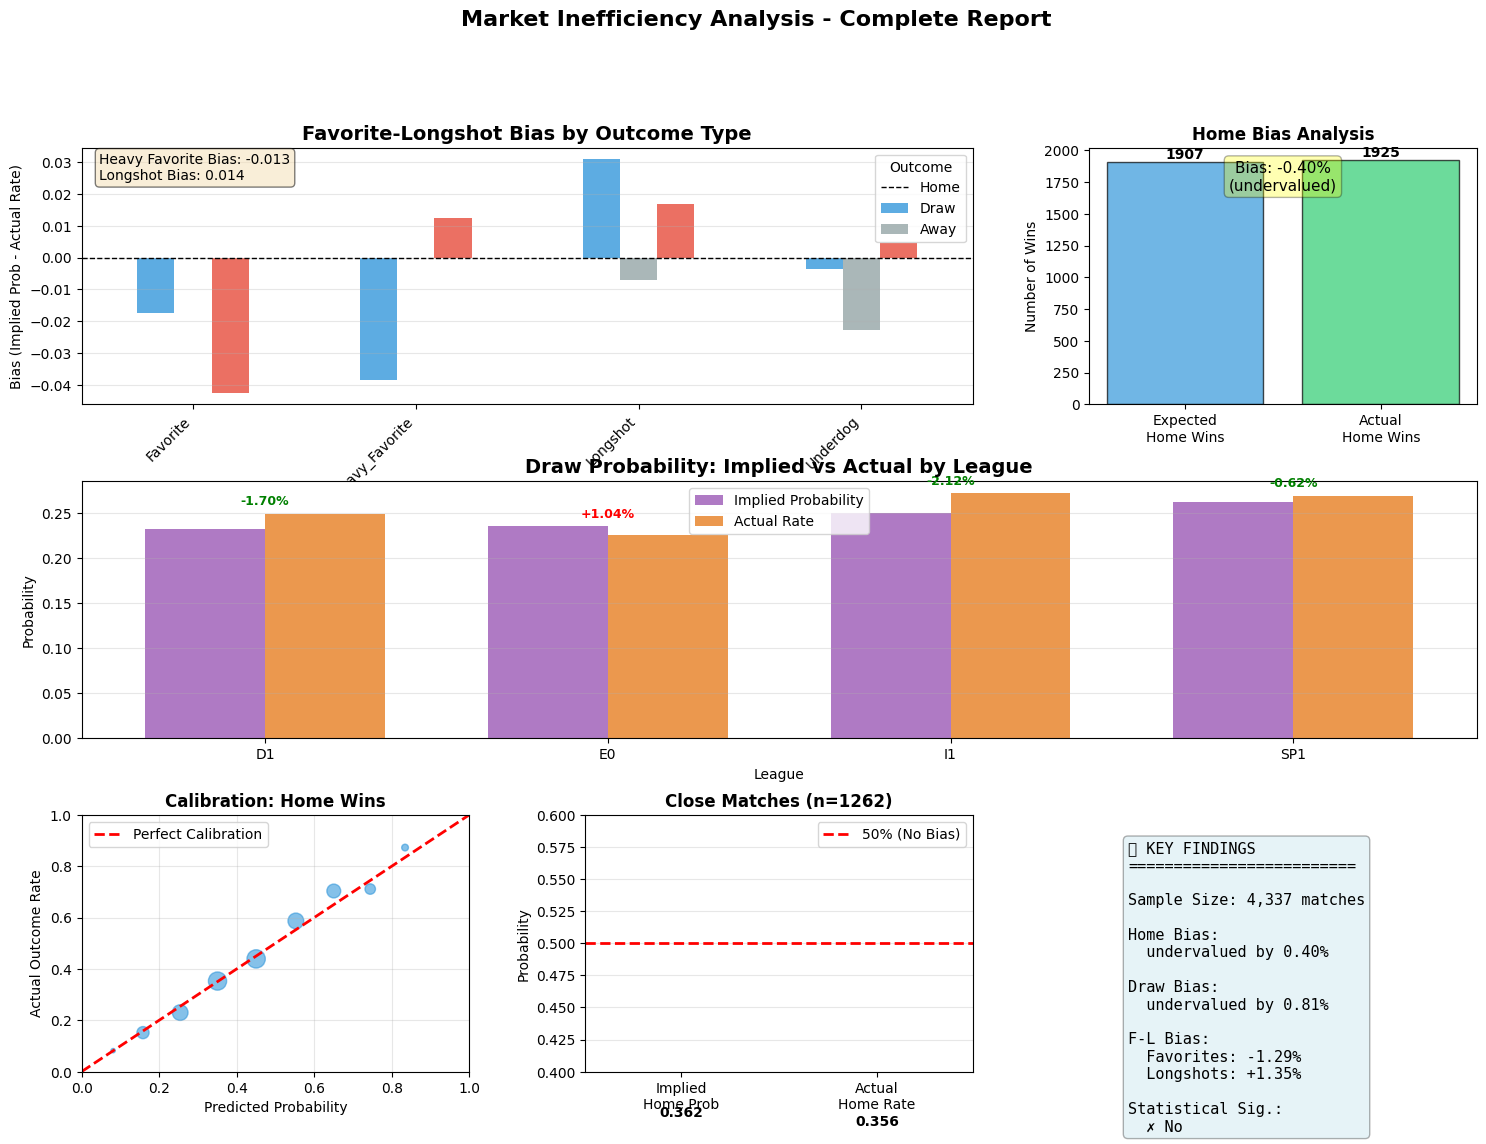

✓ Complete analysis visualization saved!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load results
with open('../results/inefficiencies.json', 'r') as f:
    inefficiencies = json.load(f)

# Load processed data
df = pd.read_csv('../data/processed/odds_processed.csv')

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Favorite-Longshot Bias
ax1 = fig.add_subplot(gs[0, :2])

fl_data = pd.DataFrame(inefficiencies['favorite_longshot']['full_analysis'])
pivot_data = fl_data.pivot(index='Bucket', columns='Outcome_Type', values='Bias')

pivot_data.plot(kind='bar', ax=ax1, color=['#3498db', '#95a5a6', '#e74c3c'], alpha=0.8)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_title('Favorite-Longshot Bias by Outcome Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Probability Bucket')
ax1.set_ylabel('Bias (Implied Prob - Actual Rate)')
ax1.legend(title='Outcome', labels=['Home', 'Draw', 'Away'])
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add interpretation box
textstr = f"Heavy Favorite Bias: {inefficiencies['favorite_longshot']['heavy_favorite_bias']:.3f}\n"
textstr += f"Longshot Bias: {inefficiencies['favorite_longshot']['longshot_bias']:.3f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# 2. Home Bias Summary
ax2 = fig.add_subplot(gs[0, 2])

home_bias = inefficiencies['home_bias']
categories = ['Expected\nHome Wins', 'Actual\nHome Wins']
values = [home_bias['expected_wins'], home_bias['actual_wins']]
colors = ['#3498db', '#2ecc71']

bars = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Home Bias Analysis', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Wins')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

bias_text = f"Bias: {home_bias['bias_percentage']:+.2%}\n({home_bias['direction']})"
ax2.text(0.5, 0.95, bias_text, transform=ax2.transAxes,
        ha='center', va='top', fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# 3. Draw Bias by League
ax3 = fig.add_subplot(gs[1, :])

draw_data = pd.DataFrame(inefficiencies['draw_bias']['by_league'])
x = np.arange(len(draw_data))
width = 0.35

bars1 = ax3.bar(x - width/2, draw_data['Implied_Draw_Prob'], width, 
               label='Implied Probability', color='#9b59b6', alpha=0.8)
bars2 = ax3.bar(x + width/2, draw_data['Actual_Draw_Rate'], width,
               label='Actual Rate', color='#e67e22', alpha=0.8)

ax3.set_xlabel('League')
ax3.set_ylabel('Probability')
ax3.set_title('Draw Probability: Implied vs Actual by League', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(draw_data['League'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add bias values on top
for i, row in draw_data.iterrows():
    bias = row['Bias']
    color = 'red' if bias > 0 else 'green'
    ax3.text(i, max(row['Implied_Draw_Prob'], row['Actual_Draw_Rate']) + 0.01,
            f'{bias:+.2%}', ha='center', fontsize=9, color=color, fontweight='bold')

# 4. Calibration Curve - FIXED
ax4 = fig.add_subplot(gs[2, 0])

# Create calibration data
bins = np.linspace(0, 1, 11)
df_temp = df[['B365_true_prob_H', 'Outcome_H']].dropna().copy()
df_temp['bin'] = pd.cut(df_temp['B365_true_prob_H'], bins=bins)

# FIXED: Proper aggregation
calibration = df_temp.groupby('bin').agg(
    Predicted=('B365_true_prob_H', 'mean'),
    Actual=('Outcome_H', 'mean'),
    Count=('B365_true_prob_H', 'count')
).reset_index(drop=True)


ax4.scatter(calibration['Predicted'], calibration['Actual'], 
           s=calibration['Count']/5, alpha=0.6, c='#3498db')
ax4.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration', linewidth=2)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Actual Outcome Rate')
ax4.set_title('Calibration: Home Wins', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

# 5. Close Match Analysis
ax5 = fig.add_subplot(gs[2, 1])

close_match = inefficiencies['close_match']
categories = ['Implied\nHome Prob', 'Actual\nHome Rate']
values = [close_match['implied_home_prob'], close_match['actual_home_rate']]

bars = ax5.bar(categories, values, color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
ax5.axhline(y=0.5, color='red', linestyle='--', label='50% (No Bias)', linewidth=2)
ax5.set_title(f'Close Matches (n={close_match["sample_size"]})', fontsize=12, fontweight='bold')
ax5.set_ylabel('Probability')
ax5.set_ylim([0.4, 0.6])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold')

# 6. Summary Stats
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

summary_text = "📊 KEY FINDINGS\n" + "="*25 + "\n\n"
summary_text += f"Sample Size: {home_bias['sample_size']:,} matches\n\n"
summary_text += f"Home Bias:\n  {home_bias['direction']} by {abs(home_bias['bias_percentage']):.2%}\n\n"
summary_text += f"Draw Bias:\n  {inefficiencies['draw_bias']['direction']} by {abs(inefficiencies['draw_bias']['overall_bias']):.2%}\n\n"
summary_text += f"F-L Bias:\n  Favorites: {inefficiencies['favorite_longshot']['heavy_favorite_bias']:+.2%}\n"
summary_text += f"  Longshots: {inefficiencies['favorite_longshot']['longshot_bias']:+.2%}\n\n"
summary_text += f"Statistical Sig.:\n  {'✓ Yes' if home_bias['statistically_significant'] else '✗ No'}"

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('Market Inefficiency Analysis - Complete Report', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('../results/complete_inefficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Complete analysis visualization saved!")